In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from operator import itemgetter

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics==8.3.40

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 24.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO('/content/yolo11x-seg.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 119M/119M [00:00<00:00, 360MB/s]


In [ ]:
IMGSZ = 640
THRESHOLD = 40
OUTLIER_PERCENTILE = 90
font = cv2.FONT_HERSHEY_SIMPLEX

## Inital Implementation

In [ ]:
image_path = "/content/0.jpg"
image = cv2.imread(image_path)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (IMGSZ, IMGSZ))
org_image = cv2.imread(image_path)
results = model(image, imgsz=IMGSZ)



0: 640x640 15 persons, 6478.8ms
Speed: 6.5ms preprocess, 6478.8ms inference, 99.4ms postprocess per image at shape (1, 3, 640, 640)


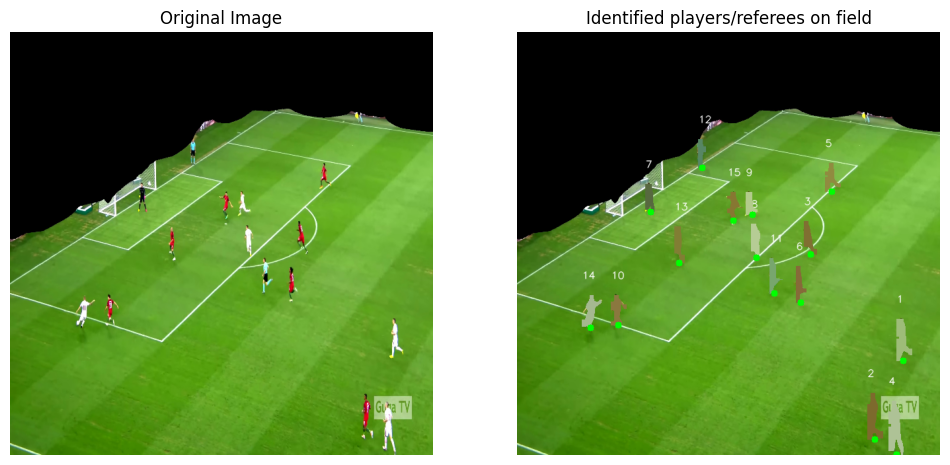

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

sc = []
mask_color = []
image2 = image.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

# Iterate through the results (each result corresponds to an image)
for result in results:
    # Get the segmentation masks, bounding boxes, and class IDs
    masks = result.masks.data  # Segmentation masks
    boxes = result.boxes  # Bounding boxes
    class_ids = boxes.cls.cpu().numpy()  # Class IDs for each detected object
    confidences = boxes.conf.cpu().numpy()  # Confidence scores for each detection

    counter = 1
    for i, mask in enumerate(masks):
        if class_ids[i] == 0:  # Check if the class is 'person' (class ID 0)
            confidence = confidences[i]  # Confidence score for the current 'person' detection

            # Convert the mask to a binary format
            binary_mask = (mask.cpu().numpy() * 255).astype("uint8")

            # Find contours from the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            sc.append(contours)

            # Draw contours on the image for only persons
            for contour in contours:
                # Calculate the bounding box of the contour
                x, y, w, h = cv2.boundingRect(contour)
                mnc_mask = np.zeros(image2.shape[:2], dtype="uint8")

                # Draw the contour on the mask
                cv2.drawContours(mnc_mask, [contour], -1, 255, thickness=cv2.FILLED)

                # Compute the mean color within the mask (for display)
                mean_color = cv2.mean(image2, mask=mnc_mask)

                # Draw the contour on the image with the mean color
                cv2.drawContours(image2, [contour], -1, mean_color[:3], thickness=cv2.FILLED)

                # Calculate the bottom coordinate (maximum y value of the contour)
                bottom_y = max(contour, key=lambda point: point[0][1])[0][1]
                bottom_x = np.mean([point[0][0] for point in contour])  # Averaging x coordinates

                # Annotate the contour with a counter, confidence, and bottom coordinate
                cv2.putText(image2, f"{counter}", (x, y - 25), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                # cv2.putText(image2, f"Conf: {confidence:.2f}", (x, y - 50), font, 1.5, (255, 255, 255), 3, cv2.LINE_AA)
                # cv2.putText(image2, f"({int(bottom_x)}, {int(bottom_y)})",
                #             (int(bottom_x), int(bottom_y) - 15),
                #             cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 1, cv2.LINE_AA)

                # Draw a point at the bottom coordinate
                cv2.circle(image2, (int(bottom_x), int(bottom_y)), 5, (0, 255, 0), -1)

                # Store the information about the detected person's color, counter, bottom coordinates, and confidence
                if (confidence > 0.5):
                    mask_color.append((mean_color[:3], counter, [int(bottom_x), int(bottom_y)], confidence))

                counter += 1

# Create a subplot to display the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the left
axes[0].imshow(image)
axes[0].axis('off')  # Hide axes
axes[0].set_title("Original Image")

# Display the image with contours and bottom coordinates on the right
axes[1].imshow(image2)
axes[1].axis('off')  # Hide axes
axes[1].set_title("Identified players/referees on field")

# Show the images
plt.show()

In [ ]:
print('Total number of players found:', len(mask_color), end='\n----------------------------------\n')

print('Printing details of player', mask_color[0][1])
print('Team color:', mask_color[0][0])
print('Coordinate:', mask_color[0][2])

Total number of players found: 15
----------------------------------
Printing details of player 1
Team color: (157.67120181405897, 187.71201814058958, 121.4297052154195)
Coordinate: [584, 497]


In [ ]:
# Sample input: list of tuples (mean_color, mask_id)
mean_colors = mask_color

# Extract the mean colors for clustering
mean_color_values = np.array([item[0] for item in mean_colors])
mask_ids = [(item[1], item[2]) for item in mean_colors]

# Step 1: Perform K-means clustering to classify into 2 main groups
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(mean_color_values)
centroids = kmeans.cluster_centers_

# Step 2: Calculate distances of each object to the centroids
distances = cdist(mean_color_values, centroids)

# Step 3: Assign masks to groups
group1, group2, group3 = [], [], []

for i, mask_id in enumerate(mask_ids):
    if labels[i] == 0 and distances[i, 0] <= distances[i, 1]:
        group1.append(mask_id)
    elif labels[i] == 1 and distances[i, 1] <= distances[i, 0]:
        group2.append(mask_id)
    else:
        group3.append(mask_id)

# Step 4: Add any outliers (far from both centroids) to Group 3
outlier_threshold = np.percentile(distances.min(axis=1), 90)
for i, dist in enumerate(distances.min(axis=1)):
    if dist > outlier_threshold:
        group3.append(mask_ids[i])
        if mask_ids[i] in group1:
            group1.remove(mask_ids[i])
        elif mask_ids[i] in group2:
            group2.remove(mask_ids[i])

# Print the results
print("Group 1 (Similar objects - Type 1):", group1)
print("Group 2 (Similar objects - Type 2):", group2)
print("Group 3 (Unclassified/Remaining):", group3)

Group 1 (Similar objects - Type 1): [(2, [541, 616]), (3, [444, 336]), (5, [476, 241]), (6, [429, 409]), (7, [202, 272]), (10, [153, 443]), (13, [245, 349]), (15, [327, 285])]
Group 2 (Similar objects - Type 2): [(1, [584, 497]), (4, [574, 639]), (8, [362, 341]), (9, [356, 276]), (14, [111, 447])]
Group 3 (Unclassified/Remaining): [(11, [389, 395]), (12, [280, 205])]


In [ ]:
group1_coordinates = [coord for _, coord in group1]
group2_coordinates = [coord for _, coord in group2]
group3_coordinates = [coord for _, coord in group3]

In [ ]:
def resize_coordinates(coords, old_width=IMGSZ, old_height=IMGSZ, new_width=512, new_height=512):
    # Calculate scaling factors for both axes
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Resize the coordinates
    resized_coords = [(int(x * scale_x), int(y * scale_y)) for x, y in coords]

    return resized_coords

In [ ]:
resized_coordinates_group1 = resize_coordinates(group1_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])
resized_coordinates_group2 = resize_coordinates(group2_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])
resized_coordinates_group3 = resize_coordinates(group3_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])

print('Group 1 coordinates:', resized_coordinates_group1)
print('Group 2 coordinates:', resized_coordinates_group2)
print('Group 3 coordinates:', resized_coordinates_group3)

Group 1 coordinates: [(2164, 1386), (1776, 756), (1904, 542), (1716, 920), (808, 612), (612, 996), (980, 785), (1308, 641)]
Group 2 coordinates: [(2336, 1118), (2296, 1437), (1448, 767), (1424, 621), (444, 1005)]
Group 3 coordinates: [(1556, 888), (1120, 461)]


In [ ]:
# Writing group_coordinates to a file for pitch sementation to read
with open('group_coordinates.txt', 'w') as file:
    # Write group 1 coordinates
    file.write('Group 1 Coordinates:\n')
    for coord in resized_coordinates_group1:
        file.write(f'{coord}\n')

    # Write group 2 coordinates
    file.write('\nGroup 2 Coordinates:\n')
    for coord in resized_coordinates_group2:
        file.write(f'{coord}\n')

    # Write group 3 coordinates
    file.write('\nGroup 3 Coordinates:\n')
    for coord in resized_coordinates_group3:
        file.write(f'{coord}\n')

print(f"Data has been written to file")

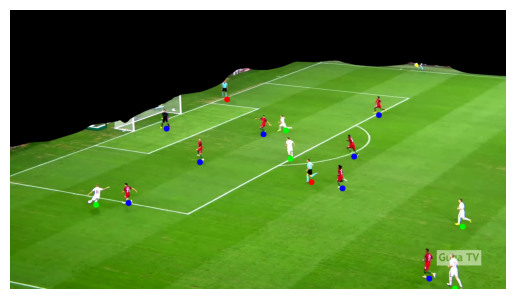

In [ ]:
org_image_copy = org_image.copy() # np.zeros((256, 256, 3), dtype=np.uint8)

# Define colors for each group (in BGR format)
color_group_1 = (255, 0, 0)  # Red
color_group_2 = (0, 255, 0)  # Green
color_group_3 = (0, 0, 255)  # Blue

# Plot the points for each group with different colors
for (x, y) in resized_coordinates_group1:
    cv2.circle(org_image_copy, (x, y), 15, color_group_1, -1)

for (x, y) in resized_coordinates_group2:
    cv2.circle(org_image_copy, (x, y), 15, color_group_2, -1)

for (x, y) in resized_coordinates_group3:
    cv2.circle(org_image_copy, (x, y), 15, color_group_3, -1)

# Convert BGR to RGB for displaying with matplotlib
org_image_copy_rgb = cv2.cvtColor(org_image_copy, cv2.COLOR_BGR2RGB)

# Display the image with the plotted points
plt.imshow(org_image_copy_rgb)
plt.axis('off')
plt.show()

## Parametrized Code

In [ ]:
def field_segmentation(image_path):
    """
    Segments the soccer field from an input image based on green chromaticity.

    Parameters:
    - image_path: Path to the input image

    Returns:
    - binary_mask: Binary mask where the field is segmented (1 for field, 0 for others)
    - segmented_image: Original image with non-field areas masked out
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to HSV color space
    blurred_hsv_image = cv2.GaussianBlur(image, (101, 101), 100)
    hsv_image = cv2.cvtColor(blurred_hsv_image, cv2.COLOR_RGB2HSV)


    # Define green color range in HSV
    # Adjust these values for robustness across lighting conditions
    lower_green = np.array([25, 30, 30])  # Adjust the lower bound of green
    upper_green = np.array([85, 255, 255])  # Adjust the upper bound of green

    # Create a binary mask for green areas
    binary_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Refine the mask using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Apply the binary mask to the original image
    segmented_image = cv2.bitwise_and(image, image, mask=binary_mask)

    return binary_mask, segmented_image, blurred_hsv_image



In [ ]:
# Function to calculate Euclidean distance
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Function to match identified to ground truth with a threshold
def match_positions(identified, ground_truth, threshold):
    matches = []
    unmatched_gt = set(range(len(ground_truth)))
    unmatched_id = set(range(len(identified)))

    for i, id_pos in enumerate(identified):
        best_match = None
        min_distance = float('inf')
        for j, gt_pos in enumerate(ground_truth):
            if j in unmatched_gt:
                distance = euclidean_distance(id_pos, gt_pos)
                if distance < min_distance and distance < threshold:
                    min_distance = distance
                    best_match = j
        if best_match is not None:
            matches.append((i, best_match))
            unmatched_gt.remove(best_match)
            unmatched_id.remove(i)

    return matches, unmatched_gt, unmatched_id


In [ ]:
def resize_coordinates(coords, old_width=IMGSZ, old_height=IMGSZ, new_width=512, new_height=512):
    # Calculate scaling factors for both axes
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Resize the coordinates
    resized_coords = [(int(x * scale_x), int(y * scale_y)) for x, y in coords]

    return resized_coords

In [ ]:
def get_coordinates_for_players(image):
    org_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMGSZ, IMGSZ))

    results = model(image, imgsz=IMGSZ)
    resized_coordinates_group1, resized_coordinates_group2, resized_coordinates_group3 = get_coordinates_by_teams(results, image, org_image)
    return resized_coordinates_group1, resized_coordinates_group2, resized_coordinates_group3

In [ ]:
def get_coordinates_by_teams(results, image, org_image):
  sc = []
  mask_color = []
  image2 = image.copy()
  font = cv2.FONT_HERSHEY_SIMPLEX

  # Iterate through the results (each result corresponds to an image)
  for result in results:
      # Get the segmentation masks, bounding boxes, and class IDs
      masks = result.masks.data  # Segmentation masks
      boxes = result.boxes  # Bounding boxes
      class_ids = boxes.cls.cpu().numpy()  # Class IDs for each detected object
      confidences = boxes.conf.cpu().numpy()  # Confidence scores for each detection

      counter = 1
      for i, mask in enumerate(masks):
          if class_ids[i] == 0:  # Check if the class is 'person' (class ID 0)
              confidence = confidences[i]  # Confidence score for the current 'person' detection
              binary_mask = (mask.cpu().numpy() * 255).astype("uint8")
              contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
              sc.append(contours)
              for contour in contours:
                  x, y, w, h = cv2.boundingRect(contour)
                  mnc_mask = np.zeros(image2.shape[:2], dtype="uint8")
                  # Compute the mean color within the mask (for display)
                                    # Draw the contour on the mask
                  cv2.drawContours(mnc_mask, [contour], -1, 255, thickness=cv2.FILLED)

                  # Compute the mean color within the mask (for display)
                  mean_color = cv2.mean(image2, mask=mnc_mask)

                  # Draw the contour on the image with the mean color
                  cv2.drawContours(image2, [contour], -1, mean_color[:3], thickness=cv2.FILLED)
                  mean_color = cv2.mean(image2, mask=mnc_mask)

                  # Calculate the bottom coordinate (maximum y value of the contour)
                  bottom_y = max(contour, key=lambda point: point[0][1])[0][1]
                  bottom_x = np.mean([point[0][0] for point in contour])
                  if (confidence > 0.5):
                      mask_color.append((mean_color[:3], counter, [int(bottom_x), int(bottom_y)], confidence))

                  counter += 1
  mean_colors = mask_color
  mean_color_values = np.array([item[0] for item in mean_colors])
  mask_ids = [(item[1], item[2]) for item in mean_colors]
  kmeans = KMeans(n_clusters=2, random_state=42)
  labels = kmeans.fit_predict(mean_color_values)
  centroids = kmeans.cluster_centers_
  distances = cdist(mean_color_values, centroids)
  group1, group2, group3 = [], [], []


  for i, mask_id in enumerate(mask_ids):
      if labels[i] == 0 and distances[i, 0] <= distances[i, 1]:
          group1.append(mask_id)
      elif labels[i] == 1 and distances[i, 1] <= distances[i, 0]:
          group2.append(mask_id)
      else:
          group3.append(mask_id)

  # Step 4: Add any outliers (far from both centroids) to Group 3
  outlier_threshold = np.percentile(distances.min(axis=1), OUTLIER_PERCENTILE)
  for i, dist in enumerate(distances.min(axis=1)):
      if dist > outlier_threshold:
          group3.append(mask_ids[i])
          if mask_ids[i] in group1:
              group1.remove(mask_ids[i])
          elif mask_ids[i] in group2:
              group2.remove(mask_ids[i])

  group1_coordinates = [coord for _, coord in group1]
  group2_coordinates = [coord for _, coord in group2]
  group3_coordinates = [coord for _, coord in group3]
  resized_coordinates_group1 = resize_coordinates(group1_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])
  resized_coordinates_group2 = resize_coordinates(group2_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])
  resized_coordinates_group3 = resize_coordinates(group3_coordinates, new_height=org_image.shape[0], new_width=org_image.shape[1])
  return resized_coordinates_group1, resized_coordinates_group2, resized_coordinates_group3


In [ ]:
def compute_metrics(resized_coordinates_group1, resized_coordinates_group2, ground_truth_team1, ground_truth_team2):
  # Align teams by minimizing total unmatched positions
  identified_team1 = resized_coordinates_group1
  identified_team2 = resized_coordinates_group2
  alignments = [
      (identified_team1, ground_truth_team1, identified_team2, ground_truth_team2),
      (identified_team1, ground_truth_team2, identified_team2, ground_truth_team1),
  ]

  best_alignment = None
  min_unmatched = float('inf')
  best_results = None
  threshold = THRESHOLD

  for team1, gt1, team2, gt2 in alignments:
      matches1, unmatched_gt1, unmatched_id1 = match_positions(team1, gt1, threshold)
      matches2, unmatched_gt2, unmatched_id2 = match_positions(team2, gt2, threshold)
      total_unmatched = len(unmatched_gt1) + len(unmatched_id1) + len(unmatched_gt2) + len(unmatched_id2)
      if total_unmatched < min_unmatched:
          min_unmatched = total_unmatched
          best_alignment = (team1, gt1, team2, gt2)
          best_results = (matches1, unmatched_gt1, unmatched_id1, matches2, unmatched_gt2, unmatched_id2)

  # Unpack best results
  identified_team1_aligned, ground_truth_team1_aligned, identified_team2_aligned, ground_truth_team2_aligned = best_alignment
  matches1, unmatched_gt1, unmatched_id1, matches2, unmatched_gt2, unmatched_id2 = best_results

  # Evaluation Metrics
  total_ground_truth = len(ground_truth_team1_aligned) + len(ground_truth_team2_aligned)
  total_identified = len(identified_team1_aligned) + len(identified_team2_aligned)
  correct_matches = len(matches1) + len(matches2)
  missed = len(unmatched_gt1) + len(unmatched_gt2)
  extra = len(unmatched_id1) + len(unmatched_id2)

  precision = correct_matches / total_identified if total_identified > 0 else 0
  recall = correct_matches / total_ground_truth if total_ground_truth > 0 else 0
  accuracy = correct_matches / (correct_matches + missed + extra) if (correct_matches + missed + extra) > 0 else 0

  return precision, recall, accuracy

  print(f"Correct matches: {correct_matches}")
  print(f"Missed ground truth players: {missed}")
  print(f"Extra identified players: {extra}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Function to extract image names and ground truth coordinates
def extract_image_coordinates(data):
    ovr_precision = 0
    ovr_recall = 0
    ovr_accuracy = 0
    count = 0
    for entry in data:  # Loop through each image entry
        image_name = entry.get("Image_ID")
        count += 1
        path = root_dir + "/" +  image_name
        _, segmented_image, _ = field_segmentation(path)
        resized_coordinates_group1, resized_coordinates_group2, resized_coordinates_group3 = get_coordinates_for_players(segmented_image)
        ground_truth_team1 = [(player["avg_x"], player["avg_y"]) for player in entry["Processed_Pose"]["Team1"]]
        ground_truth_team2 = [(player["avg_x"], player["avg_y"]) for player in entry["Processed_Pose"]["Team2"]]
        precision, recall, accuracy = compute_metrics(resized_coordinates_group1, resized_coordinates_group2, ground_truth_team1, ground_truth_team2)
        ovr_precision +=  precision
        ovr_accuracy += accuracy
        ovr_recall += recall

    print(ovr_accuracy/count, ovr_precision/count, ovr_recall/count, count)
    return ovr_precision/count, ovr_recall/count, ovr_accuracy/count

In [ ]:
import json

root_dir = "/content/drive/MyDrive/HWs Projects/Computer Vision/Final project/Offside_Images"

with open("/content/drive/MyDrive/HWs Projects/Computer Vision/Final project/processed_multiple_images.json", "r") as f:
    data = json.load(f)

# Extract the data
p,r,a = extract_image_coordinates(data)


0: 640x640 15 persons, 104.2ms
Speed: 3.9ms preprocess, 104.2ms inference, 797.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 persons, 121.2ms
Speed: 3.3ms preprocess, 121.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 18 persons, 1 car, 82.6ms
Speed: 2.3ms preprocess, 82.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 persons, 1 chair, 121.1ms
Speed: 2.2ms preprocess, 121.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 18 persons, 82.7ms
Speed: 2.5ms preprocess, 82.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 persons, 77.9ms
Speed: 2.2ms preprocess, 77.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 19 persons, 115.7ms
Speed: 2.1ms preprocess, 115.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21 persons, 84.0ms
Speed: 2.2ms preprocess, 84.0ms inference, 2.4m

In [16]:
print('Evaluation parameters', end = '\n----------------------------------\n')
print('Precision:', p)
print('Recall:', r)
print('Accuracy:', a)
print('F1 score:', 2*p*r/(p+r))

Evaluation parameters
----------------------------------
Precision: 0.8540147490450927
Recall: 0.7654436063561993
Accuracy: 0.6988152698796801
F1 score: 0.8073071187168346
